In [68]:
using JuMP, Gurobi, CSV, DataFrames,LinearAlgebra, Random, CategoricalArrays,Statistics, Plots

In [2]:
#outcome = CSV.read("outcomes_with_binary.csv")[:,13:18];
outcome = CSV.read("selectedY.csv") |> DataFrame
feature = CSV.read("selectedfeatures.csv")[:,2:end] |> DataFrame;

In [3]:
time_sentence_to_arrest = outcome[:V124];
recidivism = outcome[:V127];

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[3]:1
└ @ Core In[3]:1
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[3]:2
└ @ Core In[3]:2


In [4]:
recidivism_filtered = map( x -> begin
        if ismissing(x)
            return missing
        elseif x==8
            return missing
        else
            return x
        end
        end,recidivism);

In [5]:
sum(ismissing.(recidivism_filtered))

724

In [6]:
#indexes_recidivism = .!(ismissing.(recidivism_filtered));

In [7]:
#time_sentence_to_arrest[indexes_recidivism].==9998

In [8]:
##9998 : not ascertained, vraiment missing
## 9999 : ,ot applicable(mais pas cohérent avec V104 = nombre d ejours depuis année 1900)
#j'ai gardé 9999 as bigger than everything

time_sentence_to_arrest_filtered = map( x -> begin
        if ismissing(x)
            return missing
        elseif x==9998 #x==9999||
            return missing
        else
            return x
        end
    
        end,time_sentence_to_arrest);

In [9]:

for i=1:length(recidivism_filtered)
    if ( ismissing(recidivism_filtered[i])) || (ismissing(time_sentence_to_arrest_filtered[i]))
        #print("hey")
    elseif (recidivism_filtered[i]==1) && (time_sentence_to_arrest_filtered[i]==9999 )
        time_sentence_to_arrest_filtered[i]=missing
    end
end

In [10]:
indexes = .!(ismissing.(time_sentence_to_arrest_filtered));
time_sentence_to_arrest_filtered=time_sentence_to_arrest_filtered[indexes]
recidivism_filtered = recidivism_filtered[indexes]
feature = feature[indexes,:];


In [11]:
indexes = .!(ismissing.(recidivism_filtered))
time_sentence_to_arrest_filtered=time_sentence_to_arrest_filtered[indexes]
recidivism_filtered = recidivism_filtered[indexes]
feature = feature[indexes,:];

recidivism_filtered=Int.(recidivism_filtered)
time_sentence_to_arrest_filtered=Int.(time_sentence_to_arrest_filtered)

9695-element Array{Int64,1}:
 9999
 9999
 9999
 9999
 9999
 9999
 9999
 9999
  268
 9999
 9999
  688
 9999
    ⋮
 9999
 9999
 9999
  673
 9999
 9999
 9999
 9999
 9999
   19
 9999
 9999

In [12]:
recidivism_filtered;

In [13]:
time_sentence_to_arrest_filtered;

In [14]:
sum(ismissing.(recidivism_filtered))

0

In [18]:
feature

,V6,V8,V7,V9,V10,V11,V12
,Categorical…,Categorical…,Int64,Categorical…,Categorical…,Int64,Categorical…
1,4,800,1,1,2,998,3
2,4,810,1,1,1,43,2
3,4,810,1,8,1,60,1
4,4,700,3,1,8,998,1
5,4,520,1,1,8,998,8
6,4,520,1,1,8,40,3
7,4,110,1,1,1,998,3
8,4,320,1,1,3,998,3
9,4,200,1,1,3,35,3


In [15]:
recidivism_filtered =Bool.(recidivism_filtered)

9695-element BitArray{1}:
 0
 0
 0
 0
 0
 0
 0
 0
 1
 0
 0
 1
 0
 ⋮
 0
 0
 0
 1
 0
 0
 0
 0
 0
 1
 0
 0

In [16]:
#categorize the cogent columns
feature[:,:V6] = CategoricalArray(feature[:,:V6])
feature[:,:V8] = CategoricalArray(feature[:,:V8])
feature[:,:V9] = CategoricalArray(feature[:,:V9])
feature[:,:V10] = CategoricalArray(feature[:,:V10])
feature[:,:V12] = CategoricalArray(feature[:,:V12])
feature[:,:V13] = CategoricalArray(feature[:,:V13])
feature[:,:V15] = CategoricalArray(feature[:,:V15])
feature[:,:V16] = CategoricalArray(feature[:,:V16])
feature[:,:V17] = CategoricalArray(feature[:,:V17])
feature[:,:V20] = CategoricalArray(feature[:,:V20])
feature[:,:V25] = CategoricalArray(feature[:,:V25])
feature[:,:V26] = CategoricalArray(feature[:,:V26])
feature[:,:V27] = CategoricalArray(feature[:,:V27])
feature[:,:V28] = CategoricalArray(feature[:,:V28])
feature[:,:V30] = CategoricalArray(feature[:,:V30])
feature[:,:V31] = CategoricalArray(feature[:,:V31])
feature[:,:V32] = CategoricalArray(feature[:,:V32])
feature[:,:V33] = CategoricalArray(feature[:,:V33])
feature[:,:V34] = CategoricalArray(feature[:,:V34])
feature[:,:V35] = CategoricalArray(feature[:,:V35])
feature[:,:V36] = CategoricalArray(feature[:,:V36])
feature[:,:V37] = CategoricalArray(feature[:,:V37])
feature[:,:V38] = CategoricalArray(feature[:,:V38])
feature[:,:V39] = CategoricalArray(feature[:,:V39])
feature[:,:V40] = CategoricalArray(feature[:,:V40])
feature[:,:V63] = CategoricalArray(feature[:,:V63])
feature[:,:V113] = CategoricalArray(feature[:,:V113])
feature[:,:V114] = CategoricalArray(feature[:,:V114])
feature[:,:V130] = CategoricalArray(feature[:,:V130])
feature[:,:V134] = CategoricalArray(feature[:,:V134])
feature[:,:V136] = CategoricalArray(feature[:,:V136]);

┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, ::Colon, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[16]:1
└ @ Core In[16]:1
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, ::Colon, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[16]:3
└ @ Core In[16]:3
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, ::Colon, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[16]:4
└ @ Core In[16]:4
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, ::Colon, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = top-level scope at In[16]:5
└ @ Core In[16]:5
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, ::Colon, col_ind::ColumnIndex)` is deprecated, use `

In [17]:
##Remove variables too obvious for survival
deletecols!(feature,:V111) #risk score
deletecols!(feature,:V24); #Number of felony arrests during supervision 



┌ Warning: `deletecols!(df::DataFrame, inds)` is deprecated, use `select!(df, Not(inds))` instead.
│   caller = top-level scope at In[17]:1
└ @ Core In[17]:1
┌ Warning: `deletecols!(df::DataFrame, inds)` is deprecated, use `select!(df, Not(inds))` instead.
│   caller = top-level scope at In[17]:3
└ @ Core In[17]:3


In [28]:
feature=convert(Matrix{Float64},feature)

9695×44 Array{Float64,2}:
 4.0  800.0  1.0  1.0  2.0  998.0  3.0  …  2.0  2.0   1.0   1.0  4.0  4.0
 4.0  810.0  1.0  1.0  1.0   43.0  2.0     2.0  2.0   0.0   1.0  4.0  8.0
 4.0  810.0  1.0  8.0  1.0   60.0  1.0     2.0  2.0   0.0   1.0  2.0  1.0
 4.0  700.0  3.0  1.0  8.0  998.0  1.0     2.0  8.0   2.0   1.0  2.0  4.0
 4.0  520.0  1.0  1.0  8.0  998.0  8.0     2.0  2.0   0.0   1.0  3.0  1.0
 4.0  520.0  1.0  1.0  8.0   40.0  3.0  …  2.0  2.0   0.0   1.0  4.0  8.0
 4.0  110.0  1.0  1.0  1.0  998.0  3.0     2.0  8.0   1.0   1.0  3.0  8.0
 4.0  320.0  1.0  1.0  3.0  998.0  3.0     2.0  2.0   0.0   1.0  3.0  1.0
 4.0  200.0  1.0  1.0  3.0   35.0  3.0     2.0  2.0   0.0   1.0  2.0  1.0
 4.0  110.0  1.0  1.0  8.0  998.0  1.0     2.0  2.0   0.0   1.0  3.0  1.0
 4.0  200.0  2.0  1.0  1.0   86.0  3.0  …  1.0  2.0   0.0   1.0  3.0  1.0
 4.0  320.0  1.0  1.0  2.0   34.0  3.0     2.0  8.0   1.0   1.0  3.0  4.0
 4.0  600.0  1.0  1.0  3.0  998.0  3.0     2.0  2.0   0.0   1.0  2.0  1.0
 ⋮          

In [31]:
(train_X, train_Y), (test_X, test_Y) =
    IAI.split_data(:classification, feature, recidivism_filtered,train_proportion=0.5)
(test_X, test_Y), (val_X, val_Y) =
    IAI.split_data(:classification, test_X, test_Y,train_proportion=0.5)

(([4.0 810.0 … 2.0 1.0; 4.0 520.0 … 3.0 1.0; … ; 4.0 500.0 … 3.0 1.0; 4.0 800.0 … 2.0 1.0], Bool[0, 0, 1, 0, 0, 0, 0, 0, 0, 0  …  1, 0, 0, 1, 1, 1, 1, 0, 0, 1]), ([4.0 700.0 … 2.0 4.0; 4.0 110.0 … 3.0 8.0; … ; 4.0 600.0 … 1.0 2.0; 4.0 830.0 … 2.0 2.0], Bool[0, 0, 1, 1, 0, 0, 1, 0, 0, 0  …  0, 1, 1, 0, 0, 0, 1, 0, 1, 0]))

In [ ]:
lnr = IAI.OptimalTreeClassifier(random_seed=1,max_depth=5, cp=0.001, minbucket=10,criterion=:gini)

grid = IAI.GridSearch(lnr,
    max_depth=4:10,
    minbucket=[15,20,25],
    cp=[0.001,0.0001,0.00001]
)
IAI.fit!(grid,train_X,train_Y,val_X,val_Y)

Training trees...100%|██████████████████████████████████| Time: 0:00:08
Training trees...100%|██████████████████████████████████| Time: 0:00:08
Training trees...100%|██████████████████████████████████| Time: 0:00:07
Training trees...100%|██████████████████████████████████| Time: 0:00:08
Training trees...100%|██████████████████████████████████| Time: 0:00:08
Training trees...100%|██████████████████████████████████| Time: 0:00:07
Training trees...100%|██████████████████████████████████| Time: 0:00:08
Training trees...100%|██████████████████████████████████| Time: 0:00:08
Training trees...100%|██████████████████████████████████| Time: 0:00:08
Training trees...100%|██████████████████████████████████| Time: 0:00:13
Training trees...100%|██████████████████████████████████| Time: 0:00:12
Training trees...100%|██████████████████████████████████| Time: 0:00:12
Training trees...100%|██████████████████████████████████| Time: 0:00:13
Training trees...100%|██████████████████████████████████| Time: 

In [38]:
lnr = IAI.get_learner(grid)

Fitted OptimalTreeClassifier:
  1) Split: x42 < 14.5
    2) Split: x10 < 2.5
      3) Split: x6 < 549
        4) Split: x14 < 1.5
          5) Split: x15 < 1.5
            6) Predict: false (95.83%), [23,1], 24 points, error 1.917
            7) Predict: false (66.67%), [22,11], 33 points, error 14.67
          8) Split: x41 < 4.5
            9) Predict: false (92.65%), [718,57], 775 points, error 105.6
            10) Predict: false (98.55%), [204,3], 207 points, error 5.913
        11) Split: x7 < 2.5
          12) Split: x25 < 5
            13) Predict: false (89.02%), [235,29], 264 points, error 51.63
            14) Predict: false (100.00%), [58,0], 58 points, error 0
          15) Split: x43 < 2.5
            16) Predict: false (71.01%), [218,89], 307 points, error 126.4
            17) Predict: false (87.21%), [300,44], 344 points, error 76.74
      18) Split: x41 < 55.5
        19) Split: x41 < 0.5
          20) Split: x5 < 5.5
            21) Predict: false (65.93%), [89,46], 135 points, error 60.65
            22) Predict: false (88.89%), [240,30], 270 points, error 53.33
          23) Split: x32 < 0.5
            24) Predict: false (58.04%), [148,107], 255 points, error 124.2
            25) Predict: false (80.56%), [29,7], 36 points, error 11.28
        26) Predict: false (94.50%), [103,6], 109 points, error 11.34
    27) Split: x44 < 2.5
      28) Split: x41 < 1.5
        29) Split: x32 < 0.5
          30) Split: x34 < 35.5
            31) Predict: false (86.27%), [220,35], 255 points, error 60.39
            32) Predict: false (64.03%), [776,436], 1212 points, error 558.3
          33) Split: x5 < 1.5
            34) Predict: false (93.41%), [326,23], 349 points, error 42.97
            35) Predict: false (80.51%), [223,54], 277 points, error 86.95
        36) Split: x41 < 55.5
          37) Split: x34 < 35.5
            38) Predict: false (73.33%), [66,24], 90 points, error 35.2
            39) Predict: true (61.54%), [165,264], 429 points, error 203.1
          40) Split: x10 < 1.5
            41) Predict: false (96.09%), [172,7], 179 points, error 13.45
            42) Predict: false (84.00%), [42,8], 50 points, error 13.44
      43) Split: x5 < 1.5
        44) Split: x18 < 5.5
          45) Split: x33 < 29
            46) Predict: true (68.63%), [16,35], 51 points, error 21.96
            47) Predict: false (90.32%), [168,18], 186 points, error 32.52
          48) Split: x12 < 5
            49) Predict: false (65.22%), [30,16], 46 points, error 20.87
            50) Predict: false (100.00%), [21,0], 21 points, error 0
        51) Split: x42 < 16.5
          52) Split: x39 < 1.5
            53) Predict: false (61.94%), [153,94], 247 points, error 116.5
            54) Predict: true (63.03%), [88,150], 238 points, error 110.9
          55) Split: x42 < 20.5
            56) Predict: false (87.72%), [150,21], 171 points, error 36.84
            57) Predict: false (52.91%), [346,308], 654 points, error 325.9

In [41]:
lnr = IAI.OptimalTreeClassifier(max_depth=5, 
    cp=0.00031790294244343764, minbucket=20,criterion=:gini)


Unfitted OptimalTreeClassifier:
  max_depth: 5
  minbucket: 20
  cp:        0.00031790294244343764
  criterion: gini

In [42]:
IAI.fit!(lnr,vcat(train_X,val_X),vcat(train_Y,val_Y))

Training trees...100%|██████████████████████████████████| Time: 0:00:21


Fitted OptimalTreeClassifier:
  1) Split: x41 < 0.5
    2) Split: x33 < 46
      3) Split: x19 < 1.5
        4) Split: x42 < 15
          5) Split: x18 < 5.5
            6) Predict: false (68.89%), [31,14], 45 points, error 19.29
            7) Predict: false (91.11%), [41,4], 45 points, error 7.289
          8) Split: x20 < 5.5
            9) Predict: true (54.89%), [60,73], 133 points, error 65.86
            10) Predict: false (70.93%), [61,25], 86 points, error 35.47
        11) Split: x8 < 2.5
          12) Split: x2 < 450
            13) Predict: false (82.54%), [52,11], 63 points, error 18.16
            14) Predict: false (61.74%), [92,57], 149 points, error 70.39
          15) Split: x18 < 5.5
            16) Predict: false (51.61%), [16,15], 31 points, error 15.48
            17) Predict: false (86.71%), [137,21], 158 points, error 36.42
      18) Split: x42 < 14.5
        19) Split: x43 < 2.5
          20) Split: x7 < 2.5
            21) Predict: false (92.90%), [170,13], 183 points, error 24.15
            22) Predict: false (76.31%), [219,68], 287 points, error 103.8
          23) Split: x5 < 1.5
            24) Predict: false (97.16%), [308,9], 317 points, error 17.49
            25) Predict: false (90.00%), [567,63], 630 points, error 113.4
        26) Split: x7 < 2.5
          27) Split: x12 < 5
            28) Predict: false (85.75%), [337,56], 393 points, error 96.04
            29) Predict: false (93.84%), [274,18], 292 points, error 33.78
          30) Split: x32 < 0.5
            31) Predict: false (62.28%), [606,367], 973 points, error 457.1
            32) Predict: false (88.27%), [301,40], 341 points, error 70.62
    33) Split: x32 < 0.5
      34) Split: x41 < 1.5
        35) Split: x12 < 5
          36) Split: x30 < 549.5
            37) Predict: false (63.36%), [185,107], 292 points, error 135.6
            38) Predict: true (58.82%), [63,90], 153 points, error 74.12
          39) Split: x36 < 0.5
            40) Predict: false (55.91%), [142,112], 254 points, error 125.2
            41) Predict: false (80.44%), [181,44], 225 points, error 70.79
        42) Split: x41 < 55.5
          43) Split: x34 < 33.5
            44) Predict: false (61.09%), [135,86], 221 points, error 105.1
            45) Predict: true (58.97%), [304,437], 741 points, error 358.6
          46) Split: x42 < 15.5
            47) Predict: false (97.03%), [294,9], 303 points, error 17.47
            48) Predict: false (85.95%), [159,26], 185 points, error 44.69
      49) Split: x42 < 24.5
        50) Split: x41 < 2.5
          51) Split: x44 < 3.5
            52) Predict: false (88.02%), [191,26], 217 points, error 45.77
            53) Predict: false (71.64%), [48,19], 67 points, error 27.22
          54) Split: x41 < 9.5
            55) Predict: false (61.54%), [32,20], 52 points, error 24.62
            56) Predict: false (98.80%), [164,2], 166 points, error 3.952
        57) Split: x41 < 55.5
          58) Split: x42 < 27.5
            59) Predict: true (53.85%), [60,70], 130 points, error 64.62
            60) Predict: false (79.55%), [70,18], 88 points, error 28.64
          61) Predict: false (94.23%), [49,3], 52 points, error 5.654

In [24]:
IAI.score(lnr,test_X,test_Y,criterion=:auc)

0.7200000000000002

In [43]:
IAI.score(lnr,vcat(train_X,val_X),vcat(train_Y,val_Y),criterion=:auc)

0.7713061971721716

In [46]:
pred_return=IAI.predict_proba(lnr, vcat(train_X,val_X,test_X))[2]

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[46]:1
└ @ Core In[46]:1


9695-element Array{Float64,1}:
 0.2835820895522388  
 0.028391167192429023
 0.1                 
 0.1                 
 0.028391167192429023
 0.1                 
 0.028391167192429023
 0.23693379790940766 
 0.028391167192429023
 0.5897435897435898  
 0.13291139240506328 
 0.1                 
 0.5897435897435898  
 ⋮                   
 0.5882352941176471  
 0.5897435897435898  
 0.5897435897435898  
 0.14249363867684478 
 0.1746031746031746  
 0.5897435897435898  
 0.5897435897435898  
 0.5897435897435898  
 0.19555555555555557 
 0.5897435897435898  
 0.5897435897435898  
 0.5897435897435898  

In [55]:
pred_return=sort(pred_return)

9695-element Array{Float64,1}:
 0.012048192771084338
 0.012048192771084338
 0.012048192771084338
 0.012048192771084338
 0.012048192771084338
 0.012048192771084338
 0.012048192771084338
 0.012048192771084338
 0.012048192771084338
 0.012048192771084338
 0.012048192771084338
 0.012048192771084338
 0.012048192771084338
 ⋮                   
 0.5897435897435898  
 0.5897435897435898  
 0.5897435897435898  
 0.5897435897435898  
 0.5897435897435898  
 0.5897435897435898  
 0.5897435897435898  
 0.5897435897435898  
 0.5897435897435898  
 0.5897435897435898  
 0.5897435897435898  
 0.5897435897435898  

In [59]:
size(pred_return,1)

9695

In [84]:
function pareto(n)
           recidive=mean(pred_return[1:n])
           cost=100000*(size(pred_return,1)-n)
       return(recidive,cost)
end

pareto (generic function with 2 methods)

In [85]:
x=[pareto(i)[1] for i in 1:9695]
y=[pareto(i)[2] for i in 1:9695]

9695-element Array{Int64,1}:
 969400000
 969300000
 969200000
 969100000
 969000000
 968900000
 968800000
 968700000
 968600000
 968500000
 968400000
 968300000
 968200000
         ⋮
   1100000
   1000000
    900000
    800000
    700000
    600000
    500000
    400000
    300000
    200000
    100000
         0

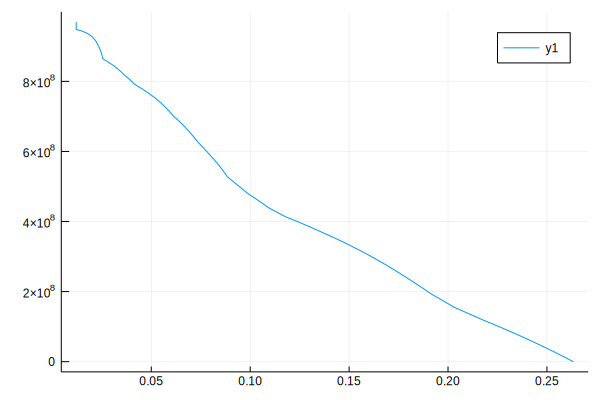

In [86]:
plot(x,y)